##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple audio recognition: Recognizing keywords

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [2]:
# !pip install -U -q tensorflow tensorflow_datasets

In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2024-04-10 10:13:57.103432: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 10:13:57.107205: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 10:13:57.154034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 10:13:58.189048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [4]:
DATASET_PATH = 'Dataset/Train'

data_dir = pathlib.Path(DATASET_PATH)
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'mini_speech_commands.zip',
#       origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#       extract=True,
#       cache_dir='.', cache_subdir='data')

 16785408/182082353 [=>............................] - ETA: 1s

 25174016/182082353 [===>..........................] - ETA: 1s

 39215104/182082353 [=====>........................] - ETA: 1s

 51994624/182082353 [=======>......................] - ETA: 0s

 65503232/182082353 [=========>....................] - ETA: 0s

 80887808/182082353 [============>.................] - ETA: 0s

 93741056/182082353 [==============>...............] - ETA: 0s

110067712/182082353 [=================>............] - ETA: 0s

124354560/182082353 [===================>..........] - ETA: 0s

140517376/182082353 [======================>.......] - ETA: 0s

158498816/182082353 [=========================>....] - ETA: 0s

172679168/182082353 [===========================>..] - ETA: 0s

182082353/182082353 [==============================] - 1s 0us/step


The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['emabega' 'unknown' 'ddyo' 'yimirira' 'kkono' 'gaali' 'mumaaso']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`. 

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [6]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 11066 files belonging to 7 classes.
Using 8853 files for training.
Using 2213 files for validation.

label names: ['ddyo' 'emabega' 'gaali' 'kkono' 'mumaaso' 'unknown' 'yimirira']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [7]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [8]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction. 

In [9]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


2024-04-10 10:13:59.306614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Let's plot a few audio waveforms:

In [11]:
label_names[[1,1,3,0]]

array(['emabega', 'emabega', 'kkono', 'ddyo'], dtype='<U8')

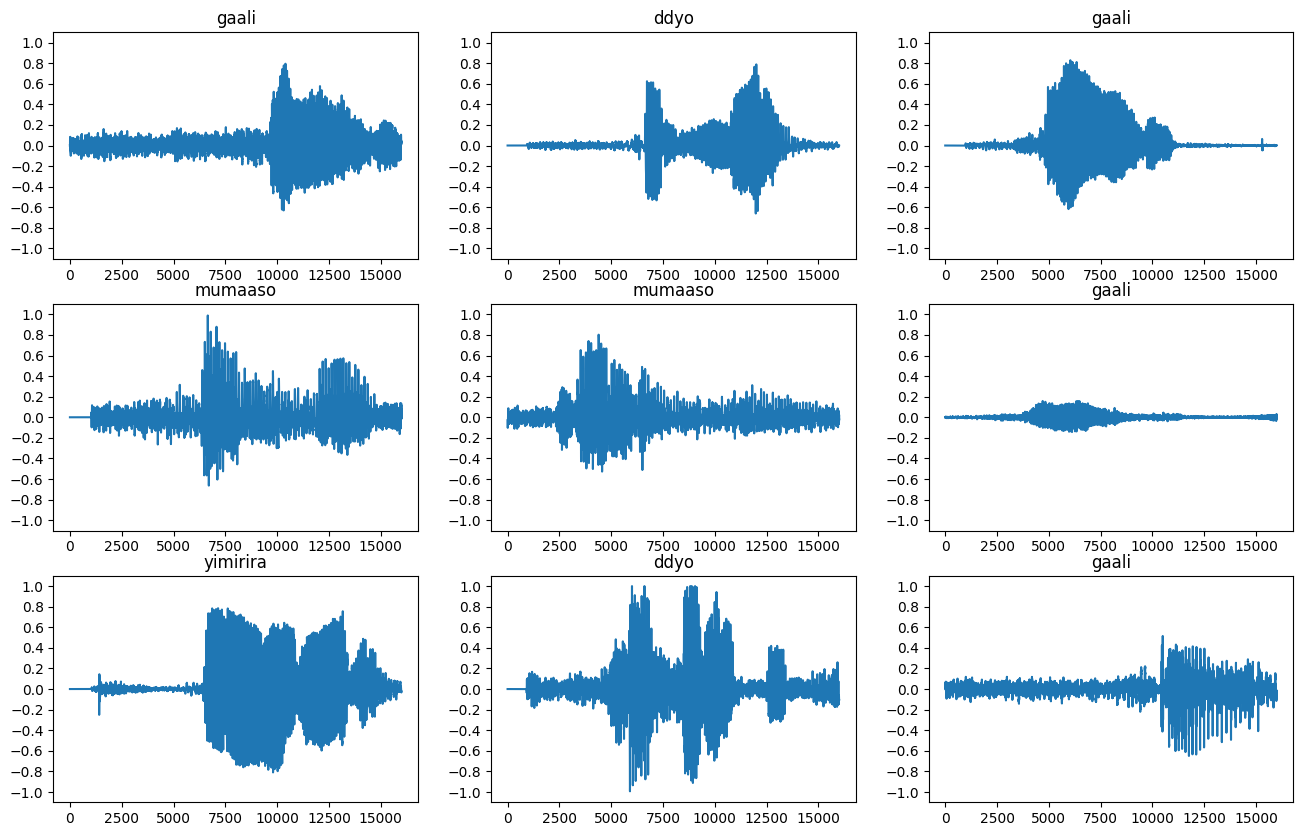

In [12]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [13]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [14]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: gaali
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: gaali
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

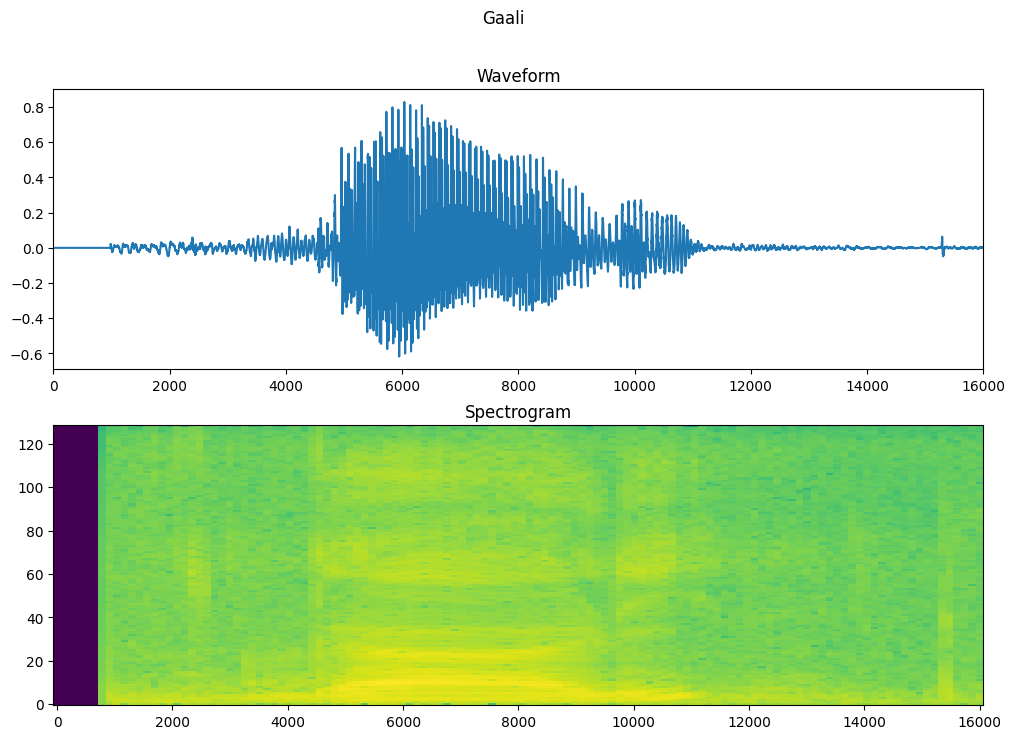

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [17]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

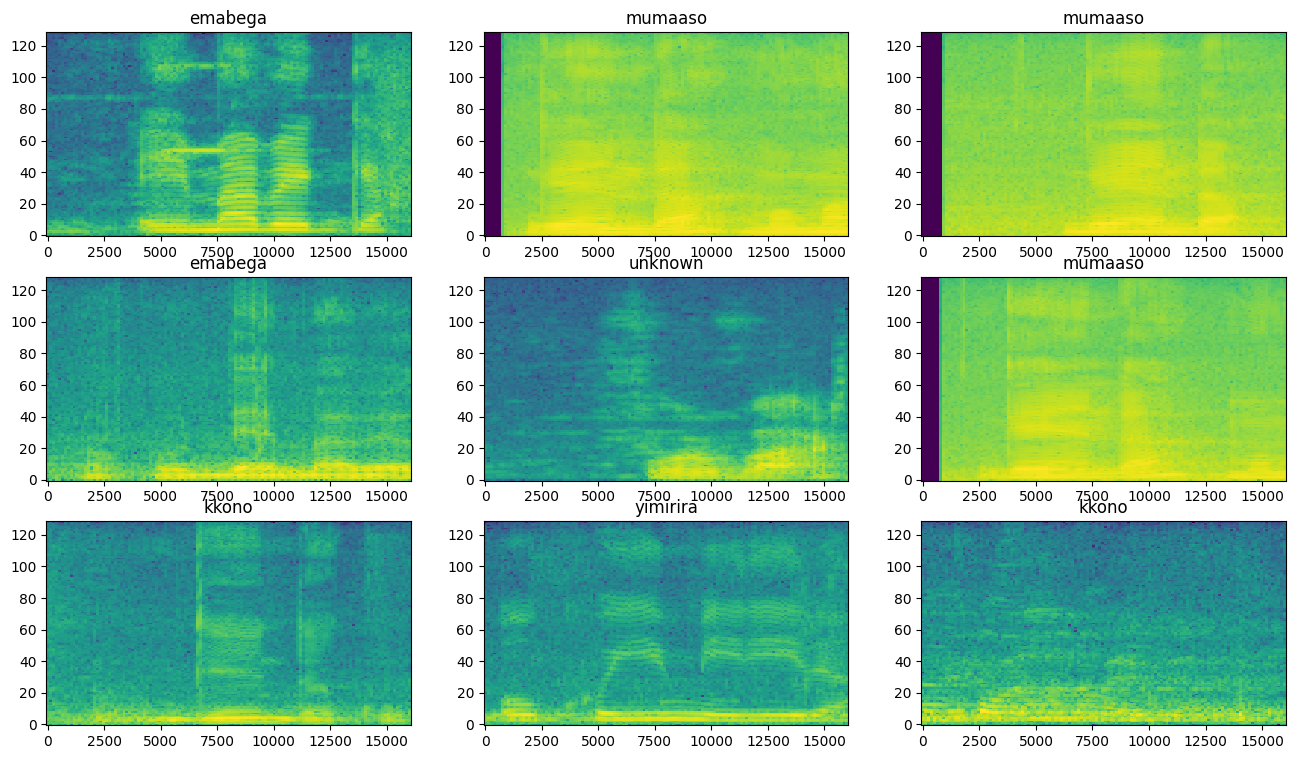

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [21]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [22]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


2024-04-10 10:14:05.132650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,482 (6.20 MB)

 Trainable params: 1,625,479 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

 resizing (Resizing)         (None, 32, 32, 1)         0         


 normalization (Normalizati  (None, 32, 32, 1)         3         


 on)                                                             


 conv2d (Conv2D)             (None, 30, 30, 32)        320       


 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     


 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         


 D)                                                              


 dropout (Dropout)           (None, 14, 14, 64)        0         


 flatten (Flatten)           (None, 12544)             0         


 dense (Dense)               (None, 128)               1605760   


 dropout_1 (Dropout)         (None, 128)               0         


 dense_1 (Dense)             (None, 8)                 1032      


Total params: 1625611 (6.20 MB)


Trainable params: 1625608 (6.20 MB)


Non-trainable params: 3 (16.00 Byte)


_________________________________________________________________


Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [24]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.4549 - loss: 1.4565 - val_accuracy: 0.7362 - val_loss: 0.8206
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.7259 - loss: 0.8099 - val_accuracy: 0.7858 - val_loss: 0.6722
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.7876 - loss: 0.6373 - val_accuracy: 0.8097 - val_loss: 0.5871
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.8175 - loss: 0.5433 - val_accuracy: 0.8373 - val_loss: 0.5296
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.8356 - loss: 0.4838 - val_accuracy: 0.8419 - val_loss: 0.5025
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.8656 - loss: 0.4019 - val_accuracy: 0.8428 - val_loss: 0.5010
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.8660 - loss: 0.3958 - val_accuracy: 0.8456 - val_loss: 0.4575
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.8788 - loss: 0.3442 - 

 35/100 [=========>....................] - ETA: 0s - loss: 2.0031 - accuracy: 0.2487

 42/100 [===========>..................] - ETA: 0s - loss: 1.9721 - accuracy: 0.2705

 49/100 [=============>................] - ETA: 0s - loss: 1.9370 - accuracy: 0.2908

 56/100 [===============>..............] - ETA: 0s - loss: 1.9208 - accuracy: 0.2994

 63/100 [=================>............] - ETA: 0s - loss: 1.8862 - accuracy: 0.3123

 70/100 [====================>.........] - ETA: 0s - loss: 1.8602 - accuracy: 0.3225

 77/100 [======================>.......] - ETA: 0s - loss: 1.8296 - accuracy: 0.3352

 84/100 [========================>.....] - ETA: 0s - loss: 1.7983 - accuracy: 0.3491

 91/100 [==========================>...] - ETA: 0s - loss: 1.7784 - accuracy: 0.3607

 98/100 [============================>.] - ETA: 0s - loss: 1.7524 - accuracy: 0.3724

100/100 [==============================] - 5s 12ms/step - loss: 1.7434 - accuracy: 0.3752 - val_loss: 1.2626 - val_accuracy: 0.6159


Epoch 2/10


  1/100 [..............................] - ETA: 0s - loss: 1.4310 - accuracy: 0.4688

  8/100 [=>............................] - ETA: 0s - loss: 1.2827 - accuracy: 0.5586

 15/100 [===>..........................] - ETA: 0s - loss: 1.2730 - accuracy: 0.5490

 22/100 [=====>........................] - ETA: 0s - loss: 1.2507 - accuracy: 0.5661

 29/100 [=======>......................] - ETA: 0s - loss: 1.2406 - accuracy: 0.5760

 36/100 [=========>....................] - ETA: 0s - loss: 1.2408 - accuracy: 0.5734

 43/100 [===========>..................] - ETA: 0s - loss: 1.2301 - accuracy: 0.5738

 50/100 [==============>...............] - ETA: 0s - loss: 1.2193 - accuracy: 0.5775

 57/100 [================>.............] - ETA: 0s - loss: 1.2053 - accuracy: 0.5855

 64/100 [==================>...........] - ETA: 0s - loss: 1.1964 - accuracy: 0.5859

 71/100 [====================>.........] - ETA: 0s - loss: 1.1907 - accuracy: 0.5874

 78/100 [======================>.......] - ETA: 0s - loss: 1.1865 - accuracy: 0.5885

 85/100 [========================>.....] - ETA: 0s - loss: 1.1733 - accuracy: 0.5925

 92/100 [==========================>...] - ETA: 0s - loss: 1.1673 - accuracy: 0.5938

 99/100 [============================>.] - ETA: 0s - loss: 1.1578 - accuracy: 0.5969

100/100 [==============================] - 1s 8ms/step - loss: 1.1574 - accuracy: 0.5969 - val_loss: 0.9141 - val_accuracy: 0.7305


Epoch 3/10


  1/100 [..............................] - ETA: 0s - loss: 0.9457 - accuracy: 0.6875

  8/100 [=>............................] - ETA: 0s - loss: 0.8862 - accuracy: 0.7129

 15/100 [===>..........................] - ETA: 0s - loss: 0.9286 - accuracy: 0.6875

 22/100 [=====>........................] - ETA: 0s - loss: 0.9005 - accuracy: 0.6882

 29/100 [=======>......................] - ETA: 0s - loss: 0.9154 - accuracy: 0.6789

 36/100 [=========>....................] - ETA: 0s - loss: 0.9256 - accuracy: 0.6745

 43/100 [===========>..................] - ETA: 0s - loss: 0.9299 - accuracy: 0.6737

 50/100 [==============>...............] - ETA: 0s - loss: 0.9301 - accuracy: 0.6778

 57/100 [================>.............] - ETA: 0s - loss: 0.9234 - accuracy: 0.6820

 64/100 [==================>...........] - ETA: 0s - loss: 0.9143 - accuracy: 0.6851

 71/100 [====================>.........] - ETA: 0s - loss: 0.9091 - accuracy: 0.6851

 78/100 [======================>.......] - ETA: 0s - loss: 0.9104 - accuracy: 0.6827

 85/100 [========================>.....] - ETA: 0s - loss: 0.9026 - accuracy: 0.6847

 92/100 [==========================>...] - ETA: 0s - loss: 0.8923 - accuracy: 0.6870

 99/100 [============================>.] - ETA: 0s - loss: 0.8931 - accuracy: 0.6872

100/100 [==============================] - 1s 8ms/step - loss: 0.8926 - accuracy: 0.6880 - val_loss: 0.7522 - val_accuracy: 0.7643


Epoch 4/10


  1/100 [..............................] - ETA: 0s - loss: 0.6921 - accuracy: 0.7500

  8/100 [=>............................] - ETA: 0s - loss: 0.7281 - accuracy: 0.7441

 15/100 [===>..........................] - ETA: 0s - loss: 0.7439 - accuracy: 0.7479

 22/100 [=====>........................] - ETA: 0s - loss: 0.7490 - accuracy: 0.7415

 29/100 [=======>......................] - ETA: 0s - loss: 0.7397 - accuracy: 0.7441

 36/100 [=========>....................] - ETA: 0s - loss: 0.7414 - accuracy: 0.7448

 43/100 [===========>..................] - ETA: 0s - loss: 0.7413 - accuracy: 0.7398

 50/100 [==============>...............] - ETA: 0s - loss: 0.7517 - accuracy: 0.7362

 57/100 [================>.............] - ETA: 0s - loss: 0.7527 - accuracy: 0.7327

 64/100 [==================>...........] - ETA: 0s - loss: 0.7511 - accuracy: 0.7314

 71/100 [====================>.........] - ETA: 0s - loss: 0.7469 - accuracy: 0.7324

 78/100 [======================>.......] - ETA: 0s - loss: 0.7429 - accuracy: 0.7344

 85/100 [========================>.....] - ETA: 0s - loss: 0.7341 - accuracy: 0.7369

 92/100 [==========================>...] - ETA: 0s - loss: 0.7333 - accuracy: 0.7369

 99/100 [============================>.] - ETA: 0s - loss: 0.7347 - accuracy: 0.7355

100/100 [==============================] - 1s 8ms/step - loss: 0.7327 - accuracy: 0.7359 - val_loss: 0.6947 - val_accuracy: 0.7812


Epoch 5/10


  1/100 [..............................] - ETA: 0s - loss: 0.8041 - accuracy: 0.7188

  8/100 [=>............................] - ETA: 0s - loss: 0.6143 - accuracy: 0.7871

 15/100 [===>..........................] - ETA: 0s - loss: 0.6267 - accuracy: 0.7740

 22/100 [=====>........................] - ETA: 0s - loss: 0.6240 - accuracy: 0.7663

 29/100 [=======>......................] - ETA: 0s - loss: 0.6290 - accuracy: 0.7732

 36/100 [=========>....................] - ETA: 0s - loss: 0.6220 - accuracy: 0.7760

 43/100 [===========>..................] - ETA: 0s - loss: 0.6316 - accuracy: 0.7725

 50/100 [==============>...............] - ETA: 0s - loss: 0.6284 - accuracy: 0.7731

 57/100 [================>.............] - ETA: 0s - loss: 0.6278 - accuracy: 0.7738

 64/100 [==================>...........] - ETA: 0s - loss: 0.6280 - accuracy: 0.7734

 71/100 [====================>.........] - ETA: 0s - loss: 0.6239 - accuracy: 0.7773

 78/100 [======================>.......] - ETA: 0s - loss: 0.6299 - accuracy: 0.7738

 85/100 [========================>.....] - ETA: 0s - loss: 0.6230 - accuracy: 0.7767

 92/100 [==========================>...] - ETA: 0s - loss: 0.6254 - accuracy: 0.7765

 99/100 [============================>.] - ETA: 0s - loss: 0.6281 - accuracy: 0.7757

100/100 [==============================] - 1s 8ms/step - loss: 0.6291 - accuracy: 0.7756 - val_loss: 0.6382 - val_accuracy: 0.8034


Epoch 6/10


  1/100 [..............................] - ETA: 0s - loss: 0.6006 - accuracy: 0.8281

  8/100 [=>............................] - ETA: 0s - loss: 0.5532 - accuracy: 0.8223

 15/100 [===>..........................] - ETA: 0s - loss: 0.5485 - accuracy: 0.8188

 22/100 [=====>........................] - ETA: 0s - loss: 0.5730 - accuracy: 0.8047

 29/100 [=======>......................] - ETA: 0s - loss: 0.5788 - accuracy: 0.8001

 36/100 [=========>....................] - ETA: 0s - loss: 0.5725 - accuracy: 0.8012

 43/100 [===========>..................] - ETA: 0s - loss: 0.5849 - accuracy: 0.7991

 50/100 [==============>...............] - ETA: 0s - loss: 0.5769 - accuracy: 0.7997

 57/100 [================>.............] - ETA: 0s - loss: 0.5663 - accuracy: 0.8007

 64/100 [==================>...........] - ETA: 0s - loss: 0.5643 - accuracy: 0.8005

 71/100 [====================>.........] - ETA: 0s - loss: 0.5627 - accuracy: 0.8017

 78/100 [======================>.......] - ETA: 0s - loss: 0.5565 - accuracy: 0.8041

 85/100 [========================>.....] - ETA: 0s - loss: 0.5563 - accuracy: 0.8040

 92/100 [==========================>...] - ETA: 0s - loss: 0.5543 - accuracy: 0.8038

 99/100 [============================>.] - ETA: 0s - loss: 0.5524 - accuracy: 0.8043

100/100 [==============================] - 1s 8ms/step - loss: 0.5495 - accuracy: 0.8056 - val_loss: 0.5947 - val_accuracy: 0.7982


Epoch 7/10


  1/100 [..............................] - ETA: 0s - loss: 0.4388 - accuracy: 0.8594

  8/100 [=>............................] - ETA: 0s - loss: 0.5070 - accuracy: 0.8105

 15/100 [===>..........................] - ETA: 0s - loss: 0.5234 - accuracy: 0.8125

 22/100 [=====>........................] - ETA: 0s - loss: 0.5107 - accuracy: 0.8239

 29/100 [=======>......................] - ETA: 0s - loss: 0.5093 - accuracy: 0.8233

 36/100 [=========>....................] - ETA: 0s - loss: 0.5090 - accuracy: 0.8242

 43/100 [===========>..................] - ETA: 0s - loss: 0.5035 - accuracy: 0.8241

 50/100 [==============>...............] - ETA: 0s - loss: 0.5036 - accuracy: 0.8222

 57/100 [================>.............] - ETA: 0s - loss: 0.4962 - accuracy: 0.8259

 64/100 [==================>...........] - ETA: 0s - loss: 0.4966 - accuracy: 0.8254

 71/100 [====================>.........] - ETA: 0s - loss: 0.4951 - accuracy: 0.8270

 78/100 [======================>.......] - ETA: 0s - loss: 0.4976 - accuracy: 0.8249

 85/100 [========================>.....] - ETA: 0s - loss: 0.5019 - accuracy: 0.8226

 92/100 [==========================>...] - ETA: 0s - loss: 0.5020 - accuracy: 0.8225

 99/100 [============================>.] - ETA: 0s - loss: 0.5064 - accuracy: 0.8207

100/100 [==============================] - 1s 8ms/step - loss: 0.5055 - accuracy: 0.8213 - val_loss: 0.5552 - val_accuracy: 0.8281


Epoch 8/10


  1/100 [..............................] - ETA: 0s - loss: 0.4320 - accuracy: 0.8594

  8/100 [=>............................] - ETA: 0s - loss: 0.4120 - accuracy: 0.8672

 15/100 [===>..........................] - ETA: 0s - loss: 0.4024 - accuracy: 0.8604

 22/100 [=====>........................] - ETA: 0s - loss: 0.4150 - accuracy: 0.8537

 29/100 [=======>......................] - ETA: 0s - loss: 0.4301 - accuracy: 0.8475

 37/100 [==========>...................] - ETA: 0s - loss: 0.4501 - accuracy: 0.8383

 44/100 [============>.................] - ETA: 0s - loss: 0.4487 - accuracy: 0.8398

 51/100 [==============>...............] - ETA: 0s - loss: 0.4461 - accuracy: 0.8416

 58/100 [================>.............] - ETA: 0s - loss: 0.4432 - accuracy: 0.8440

 65/100 [==================>...........] - ETA: 0s - loss: 0.4386 - accuracy: 0.8462

 72/100 [====================>.........] - ETA: 0s - loss: 0.4419 - accuracy: 0.8459

 79/100 [======================>.......] - ETA: 0s - loss: 0.4436 - accuracy: 0.8453

 86/100 [========================>.....] - ETA: 0s - loss: 0.4411 - accuracy: 0.8470

 93/100 [==========================>...] - ETA: 0s - loss: 0.4411 - accuracy: 0.8468

100/100 [==============================] - ETA: 0s - loss: 0.4423 - accuracy: 0.8461

100/100 [==============================] - 1s 8ms/step - loss: 0.4423 - accuracy: 0.8461 - val_loss: 0.5224 - val_accuracy: 0.8411


Epoch 9/10


  1/100 [..............................] - ETA: 0s - loss: 0.3651 - accuracy: 0.8594

  8/100 [=>............................] - ETA: 0s - loss: 0.3892 - accuracy: 0.8516

 15/100 [===>..........................] - ETA: 0s - loss: 0.3717 - accuracy: 0.8677

 22/100 [=====>........................] - ETA: 0s - loss: 0.3885 - accuracy: 0.8594

 29/100 [=======>......................] - ETA: 0s - loss: 0.3888 - accuracy: 0.8642

 36/100 [=========>....................] - ETA: 0s - loss: 0.3956 - accuracy: 0.8620

 43/100 [===========>..................] - ETA: 0s - loss: 0.4074 - accuracy: 0.8583

 50/100 [==============>...............] - ETA: 0s - loss: 0.4031 - accuracy: 0.8597

 57/100 [================>.............] - ETA: 0s - loss: 0.4106 - accuracy: 0.8555

 64/100 [==================>...........] - ETA: 0s - loss: 0.4102 - accuracy: 0.8572

 71/100 [====================>.........] - ETA: 0s - loss: 0.4063 - accuracy: 0.8583

 78/100 [======================>.......] - ETA: 0s - loss: 0.4075 - accuracy: 0.8586

 85/100 [========================>.....] - ETA: 0s - loss: 0.4084 - accuracy: 0.8572

 92/100 [==========================>...] - ETA: 0s - loss: 0.4074 - accuracy: 0.8572

 99/100 [============================>.] - ETA: 0s - loss: 0.4062 - accuracy: 0.8580

100/100 [==============================] - 1s 8ms/step - loss: 0.4088 - accuracy: 0.8572 - val_loss: 0.4882 - val_accuracy: 0.8464


Epoch 10/10


  1/100 [..............................] - ETA: 0s - loss: 0.4479 - accuracy: 0.8438

  8/100 [=>............................] - ETA: 0s - loss: 0.3259 - accuracy: 0.8750

 15/100 [===>..........................] - ETA: 0s - loss: 0.3298 - accuracy: 0.8708

 22/100 [=====>........................] - ETA: 0s - loss: 0.3435 - accuracy: 0.8750

 29/100 [=======>......................] - ETA: 0s - loss: 0.3379 - accuracy: 0.8772

 36/100 [=========>....................] - ETA: 0s - loss: 0.3405 - accuracy: 0.8789

 43/100 [===========>..................] - ETA: 0s - loss: 0.3433 - accuracy: 0.8783

 50/100 [==============>...............] - ETA: 0s - loss: 0.3405 - accuracy: 0.8803

 57/100 [================>.............] - ETA: 0s - loss: 0.3383 - accuracy: 0.8810

 64/100 [==================>...........] - ETA: 0s - loss: 0.3346 - accuracy: 0.8828

 71/100 [====================>.........] - ETA: 0s - loss: 0.3401 - accuracy: 0.8823

 78/100 [======================>.......] - ETA: 0s - loss: 0.3412 - accuracy: 0.8828

 85/100 [========================>.....] - ETA: 0s - loss: 0.3440 - accuracy: 0.8811

 92/100 [==========================>...] - ETA: 0s - loss: 0.3473 - accuracy: 0.8786

 99/100 [============================>.] - ETA: 0s - loss: 0.3489 - accuracy: 0.8788

100/100 [==============================] - 1s 8ms/step - loss: 0.3496 - accuracy: 0.8786 - val_loss: 0.4704 - val_accuracy: 0.8529


Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

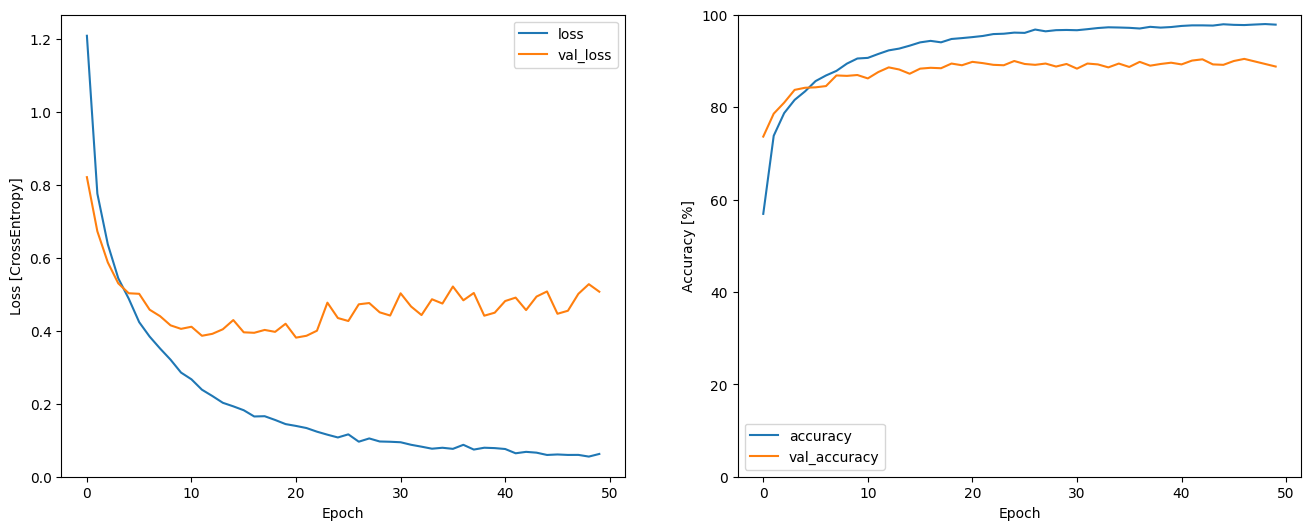

In [25]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [26]:
model.evaluate(test_spectrogram_ds, return_dict=True)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9008 - loss: 0.4209


{'accuracy': 0.902222216129303, 'loss': 0.49220478534698486}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [27]:
y_pred = model.predict(test_spectrogram_ds)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [28]:
y_pred = tf.argmax(y_pred, axis=1)

In [29]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

2024-04-10 10:24:16.289012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


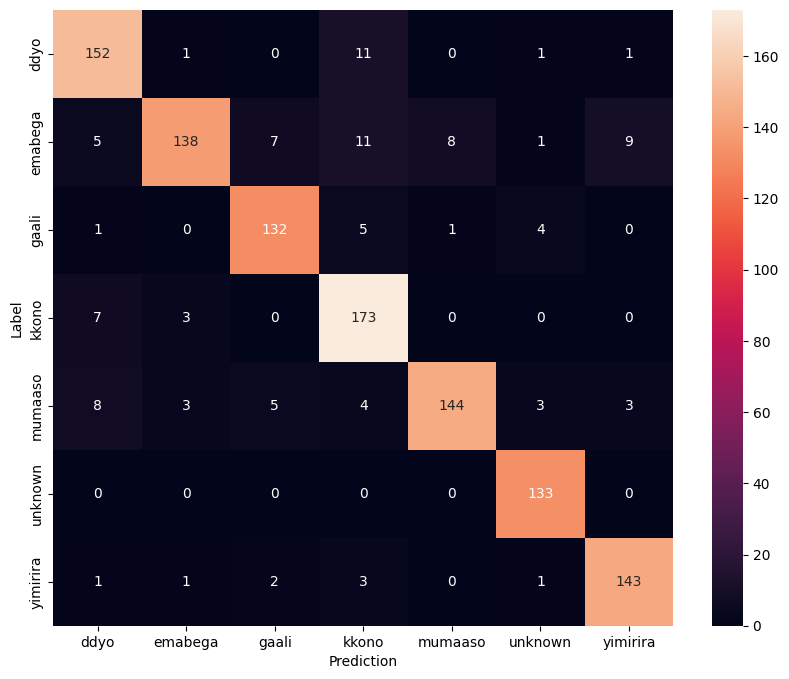

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (6,) and arg 1 with shape (7,).

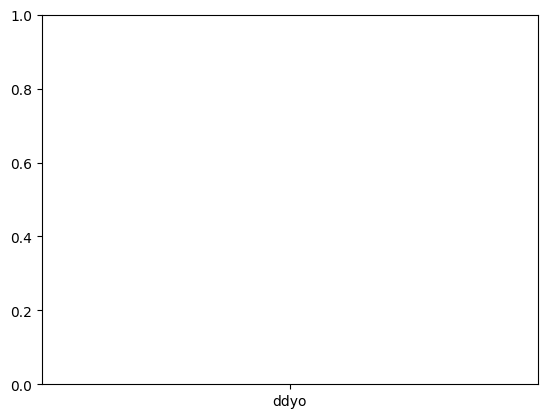

In [32]:
x = data_dir/'kkono'/'kkono_67.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['ddyo' ,'emabega' ,'gaali', 'kkono', 'mu masso' ,'yimirira']
# x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('ddyo')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [ ]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'kkono'/'kkono #67.wav')))

Save and reload the model, the reloaded model gives identical output:

In [ ]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The 
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.